In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

plt.style.use("fivethirtyeight")

path = ""

In [2]:
# Uncomment cell if using Google Colab

from google.colab import drive
drive.mount("/content/drive")

path = "/content/drive/My Drive/csc-461-final-project/"

Mounted at /content/drive


In [3]:
Statewide = pd.read_csv(path + "data/Statewide.csv")
Statewide.head()

,CITY,ZIP CODE,CURRENT PARTY,YEAR OF BIRTH,ELECTION 3,ELECTION 4,ELECTION 5,ELECTION 6,ELECTION 7,ELECTION 8,PARTY 5,PARTY 6,PARTY 8,TGT STATEWIDE PRIMARY,TGT PARTY AFFILIATION
0,6,2921,1,1962,1,1,1,0,1,1,3,0,2,0,0
1,6,2920,2,1984,0,1,0,0,0,0,0,0,0,0,0
2,32,2878,3,1968,1,1,0,1,1,1,0,3,3,1,3
3,32,2878,3,1962,1,1,0,1,1,0,0,3,0,1,3
4,34,2889,3,1996,0,1,0,0,0,0,0,0,0,0,0


In [4]:
from sklearn.model_selection import RepeatedStratifiedKFold, train_test_split, GridSearchCV
from sklearn.metrics import roc_auc_score

In [5]:
Statewide_target = Statewide["TGT STATEWIDE PRIMARY"]
Statewide = Statewide.drop(["TGT STATEWIDE PRIMARY", "TGT PARTY AFFILIATION"], axis = 1)

In [6]:
Statewide.head()

,CITY,ZIP CODE,CURRENT PARTY,YEAR OF BIRTH,ELECTION 3,ELECTION 4,ELECTION 5,ELECTION 6,ELECTION 7,ELECTION 8,PARTY 5,PARTY 6,PARTY 8
0,6,2921,1,1962,1,1,1,0,1,1,3,0,2
1,6,2920,2,1984,0,1,0,0,0,0,0,0,0
2,32,2878,3,1968,1,1,0,1,1,1,0,3,3
3,32,2878,3,1962,1,1,0,1,1,0,0,3,0
4,34,2889,3,1996,0,1,0,0,0,0,0,0,0


In [7]:
Statewide_target.head()

0    0
1    0
2    1
3    1
4    0
Name: TGT STATEWIDE PRIMARY, dtype: int64

In [8]:
X_train, X_test, y_train, y_test = train_test_split(Statewide, Statewide_target, test_size = .50, stratify = Statewide_target)

print("Train features shape:", X_train.shape)
print("Test features shape:", X_test.shape)

logreg = LogisticRegression()
solvers = ["lbfgs"]
penalties = ["l2"]
C_vals = [100, 10, 1.0, 0.1, 0.01]
max_iter = [1000]
weights = [None, "balanced"]
param_grid = dict(solver = solvers, penalty = penalties, C = C_vals, class_weight = weights, max_iter = max_iter)
print(param_grid)

cv = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 3)
grid = GridSearchCV(estimator = logreg, param_grid = param_grid, cv = cv, scoring = "average_precision", return_train_score = True, verbose = 10)

grid_search = grid.fit(X_train, y_train)

Train features shape: (408148, 13)
Test features shape: (408149, 13)
{'solver': ['lbfgs'], 'penalty': ['l2'], 'C': [100, 10, 1.0, 0.1, 0.01], 'class_weight': [None, 'balanced'], 'max_iter': [1000]}
Fitting 30 folds for each of 10 candidates, totalling 300 fits
[CV 1/30; 1/10] START C=100, class_weight=None, max_iter=1000, penalty=l2, solver=lbfgs
[CV 1/30; 1/10] END C=100, class_weight=None, max_iter=1000, penalty=l2, solver=lbfgs;, score=(train=0.607, test=0.613) total time=  16.0s
[CV 2/30; 1/10] START C=100, class_weight=None, max_iter=1000, penalty=l2, solver=lbfgs
[CV 2/30; 1/10] END C=100, class_weight=None, max_iter=1000, penalty=l2, solver=lbfgs;, score=(train=0.607, test=0.612) total time=  12.9s
[CV 3/30; 1/10] START C=100, class_weight=None, max_iter=1000, penalty=l2, solver=lbfgs
[CV 3/30; 1/10] END C=100, class_weight=None, max_iter=1000, penalty=l2, solver=lbfgs;, score=(train=0.598, test=0.600) total time=   7.1s
[CV 4/30; 1/10] START C=100, class_weight=None, max_iter=1

In [9]:
print(grid_search.best_params_)

{'C': 0.1, 'class_weight': None, 'max_iter': 1000, 'penalty': 'l2', 'solver': 'lbfgs'}


In [10]:
accuracy = grid_search.best_score_ 
print("Best AUC-PR: {}".format(accuracy))

Best Avg. Precision: 0.6107182545420033


In [ ]:
%pip install wandb

In [12]:
import wandb
wandb.login
wandb.init(config=grid_search.best_params_)

ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 

··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [14]:
logreg = LogisticRegression(**grid_search.best_params_)
logreg.fit(X_train, y_train)
test_pred = logreg.predict(X_test)
test_proba = logreg.predict_proba(X_test)
test_accuracy = roc_auc_score(y_test, logreg.predict_proba(X_test)[:,1])

print("AUC-ROC: {}".format(test_accuracy))
print("AUC-PR {}".format(sklearn.metrics.average_precision_score(y_test, logreg.predict_proba(X_test)[:,1])))

from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, matthews_corrcoef

print('\nF1 Score: {}'.format(
    f1_score(y_test, test_pred, average = "weighted")))
print('Precision: {}'.format(
    precision_score(y_test, test_pred, average = "weighted")))
print('Recall: {}'.format(
    recall_score(y_test, test_pred, average = "weighted")))
print('Accuracy: {}'.format(
    accuracy_score(y_test, test_pred)))
print('MCC: {}'.format(
    matthews_corrcoef(y_test, test_pred)))

AUC-ROC: 0.8711478616969073
AUC-PR 0.6002046585153992

F1 Score: 0.8573156876691104
Precision: 0.855744335718822
Recall: 0.8688077148296333
Accuracy: 0.8688077148296333
MCC: 0.47098552355863554


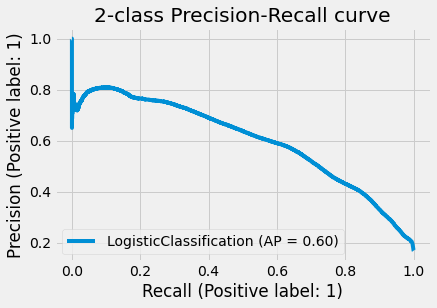

In [15]:
from sklearn.metrics import PrecisionRecallDisplay

display = PrecisionRecallDisplay.from_estimator(
    logreg, X_test, y_test, name="LogisticClassification"
)
_ = display.ax_.set_title("2-class Precision-Recall curve")

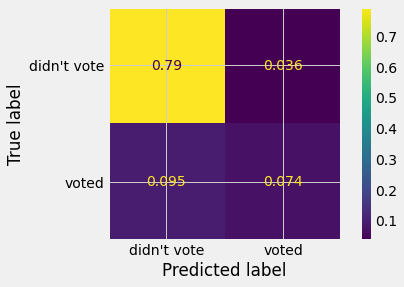

In [20]:
cm = confusion_matrix(y_test, test_pred, normalize = "all", labels=[0, 1])
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = ["didn't vote", "voted"])
# wandb.sklearn.plot_confusion_matrix(y_test, test_pred, ["didn't vote", "voted"]) 
disp.plot()
plt.show()

In [ ]:

wandb.sklearn.plot_classifier(logreg, X_train, X_test, y_train, y_test, test_pred, test_proba, ["didn't vote", "voted"], model_name='LogisticRegression', feature_names = X_train.columns)

In [19]:
wandb.finish()